In [1]:
import json 
import os
import collections
import tensorflow as tf 
import re
import h5py
import argparse
import sys 
import numpy as np 
import pandas as pd
import pickle
from nltk.translate.bleu_score import corpus_bleu

## LOAD PREPROCESSED TRAINING DATASET

In [2]:
#Load necessary files: Here we have loaded file for training
df_final = pickle.load(open('train_df_final.pkl', 'rb'))
features = pickle.load(open('image_feature_train.pkl', 'rb'))
word_to_idx = pickle.load(open('word_to_idx.pkl', 'rb'))
idx_to_word = pickle.load(open('idx_to_word.pkl', 'rb'))

In [3]:
import keras
from keras.layers import Input, Activation, Embedding, merge, LSTM, Dropout, Dense, RepeatVector, BatchNormalization, \
    TimeDistributed, Flatten, Reshape
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras import optimizers

Using TensorFlow backend.


## TRAINING

In [4]:
from pandas import read_csv, DataFrame
from numpy.random import seed

from keras.models import Sequential
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Dense, merge
from keras.layers.normalization import BatchNormalization
from keras.layers import concatenate

In [6]:
PADDING_LEN = 17
vocabulary_size=len(word_to_idx)
embed_size=150
question_max_len=PADDING_LEN-1
answer_max_len=PADDING_LEN-1
# Image
k_image_input = Input(shape=(4096,))
k_image_repeat = RepeatVector(n=question_max_len)(k_image_input)

# Question
k_question_input = Input(shape=(question_max_len,), dtype='int32')
k_question_embedded = Embedding(input_dim=vocabulary_size, output_dim=embed_size, input_length=question_max_len)(k_question_input)  
k_question_embedded = Dropout(0.3)(k_question_embedded)

# Merge
k_merged = concatenate([k_image_repeat, k_question_embedded])  # Merge for layers merge for tensors
k_merged = BatchNormalization()(k_merged)

#Set encoder
k_encoder_outputs, k_state_h, k_state_c  = LSTM(embed_size, return_state=True)(k_merged)
k_encoder_outputs = Dropout(0.3)(k_encoder_outputs)
k_encoder_states = [k_state_h, k_state_c]
embed_size

# Set up the decoder, using `encoder_states` as initial state.
k_decoder_inputs = Input(shape=(None, vocabulary_size))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
k_decoder_lstm = LSTM(embed_size, return_sequences=True, return_state=True)
k_decoder_outputs, _, _ = k_decoder_lstm(k_decoder_inputs, initial_state=k_encoder_states)

#Final Layer
k_decoder_dense = Dense(vocabulary_size, activation='softmax')
k_decoder_outputs = k_decoder_dense(k_decoder_outputs)

model = Model([k_image_input, k_question_input, k_decoder_inputs], k_decoder_outputs)
print('Model created')
print('Compiling model...')
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
print('Model compiled')

Model created
Compiling model...
Model compiled


In [7]:
image_input=np.array(features)
question_inputs=np.array(df_final['Q_Encoded'])
question_inputs=np.array([np.array(item) for item in question_inputs])
decoder_inputs =np.array(df_final['A_Encoded'])
decoder_targets =np.array(df_final['A_Encoded'])

In [8]:
m_question_input_data = np.zeros(
    (len(question_inputs), PADDING_LEN-1, vocabulary_size),
    dtype='float32')
m_decoder_inputs = np.zeros(
    (len(decoder_inputs), PADDING_LEN-1, vocabulary_size),
    dtype='float32')
m_decoder_targets= np.zeros(
    (len(decoder_targets), PADDING_LEN-1, vocabulary_size),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(question_inputs, decoder_inputs)):
    for t, char in enumerate(input_text):
        m_question_input_data[i, t, char] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        m_decoder_inputs[i, t, char] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            m_decoder_targets[i, t - 1, char] = 1.

In [9]:
question_inputs=np.array([np.array(item) for item in question_inputs])
m_decoder_inputs.shape

(1933, 16, 1283)

In [10]:
train_out = model.fit([features,question_inputs, m_decoder_inputs], m_decoder_targets, batch_size=100, epochs=400, validation_split=0.2)

Train on 1546 samples, validate on 387 samples
Epoch 1/400
1546/1546 [==============================] - 13s 8ms/step - loss: 2.7002 - acc: 0.7851 - val_loss: 0.9653 - val_acc: 0.8324
Epoch 2/400
1546/1546 [==============================] - 1s 778us/step - loss: 0.7426 - acc: 0.8444 - val_loss: 0.8752 - val_acc: 0.8324
Epoch 3/400
1546/1546 [==============================] - 1s 776us/step - loss: 0.6534 - acc: 0.8663 - val_loss: 0.8161 - val_acc: 0.8792
Epoch 4/400
1546/1546 [==============================] - 1s 785us/step - loss: 0.6056 - acc: 0.8851 - val_loss: 0.8096 - val_acc: 0.8784
Epoch 5/400
1546/1546 [==============================] - 1s 771us/step - loss: 0.5705 - acc: 0.9011 - val_loss: 0.7746 - val_acc: 0.8911
Epoch 6/400
1546/1546 [==============================] - 1s 792us/step - loss: 0.5330 - acc: 0.9113 - val_loss: 0.7725 - val_acc: 0.8782
Epoch 7/400
1546/1546 [==============================] - 1s 782us/step - loss: 0.4957 - acc: 0.9122 - val_loss: 0.8099 - val_acc: 0.

1546/1546 [==============================] - 1s 782us/step - loss: 4.9740e-04 - acc: 0.9999 - val_loss: 0.9945 - val_acc: 0.9052
Epoch 120/400
1546/1546 [==============================] - 1s 795us/step - loss: 4.1000e-04 - acc: 0.9998 - val_loss: 1.0048 - val_acc: 0.9041
Epoch 121/400
1546/1546 [==============================] - 1s 801us/step - loss: 8.6512e-04 - acc: 0.9998 - val_loss: 0.9935 - val_acc: 0.9065
Epoch 122/400
1546/1546 [==============================] - 1s 783us/step - loss: 0.0040 - acc: 0.9990 - val_loss: 0.9762 - val_acc: 0.9055
Epoch 123/400
1546/1546 [==============================] - 1s 777us/step - loss: 0.0012 - acc: 0.9995 - val_loss: 0.9793 - val_acc: 0.9070
Epoch 124/400
1546/1546 [==============================] - 1s 779us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.9685 - val_acc: 0.9071
Epoch 125/400
1546/1546 [==============================] - 1s 787us/step - loss: 4.7483e-04 - acc: 0.9998 - val_loss: 0.9802 - val_acc: 0.9073
Epoch 126/400
1546/1546 [

Epoch 177/400
1546/1546 [==============================] - 1s 805us/step - loss: 9.4582e-04 - acc: 0.9996 - val_loss: 1.0443 - val_acc: 0.9067
Epoch 178/400
1546/1546 [==============================] - 1s 794us/step - loss: 0.0019 - acc: 0.9995 - val_loss: 1.0419 - val_acc: 0.9065
Epoch 179/400
1546/1546 [==============================] - 1s 785us/step - loss: 8.6054e-04 - acc: 0.9997 - val_loss: 1.0408 - val_acc: 0.9060
Epoch 180/400
1546/1546 [==============================] - 1s 795us/step - loss: 8.6825e-04 - acc: 0.9997 - val_loss: 1.0415 - val_acc: 0.9070
Epoch 181/400
1546/1546 [==============================] - 1s 784us/step - loss: 0.0011 - acc: 0.9995 - val_loss: 1.0213 - val_acc: 0.9070
Epoch 182/400
1546/1546 [==============================] - 1s 780us/step - loss: 5.3997e-04 - acc: 0.9998 - val_loss: 1.0143 - val_acc: 0.9081
Epoch 183/400
1546/1546 [==============================] - 1s 784us/step - loss: 3.4862e-04 - acc: 0.9998 - val_loss: 1.0219 - val_acc: 0.9070
Epoch 1

1546/1546 [==============================] - 1s 789us/step - loss: 1.9726e-04 - acc: 0.9998 - val_loss: 1.0731 - val_acc: 0.9083
Epoch 292/400
1546/1546 [==============================] - 1s 780us/step - loss: 3.3947e-04 - acc: 0.9998 - val_loss: 1.0720 - val_acc: 0.9071
Epoch 293/400
1546/1546 [==============================] - 1s 775us/step - loss: 4.7126e-04 - acc: 0.9997 - val_loss: 1.0692 - val_acc: 0.9081
Epoch 294/400
1546/1546 [==============================] - 1s 781us/step - loss: 6.9729e-04 - acc: 0.9997 - val_loss: 1.0654 - val_acc: 0.9078
Epoch 295/400
1546/1546 [==============================] - 1s 779us/step - loss: 7.4084e-04 - acc: 0.9997 - val_loss: 1.0613 - val_acc: 0.9070
Epoch 296/400
1546/1546 [==============================] - 1s 782us/step - loss: 4.5450e-04 - acc: 0.9998 - val_loss: 1.0599 - val_acc: 0.9073
Epoch 297/400
1546/1546 [==============================] - 1s 784us/step - loss: 2.0365e-04 - acc: 0.9998 - val_loss: 1.0575 - val_acc: 0.9086
Epoch 298/400

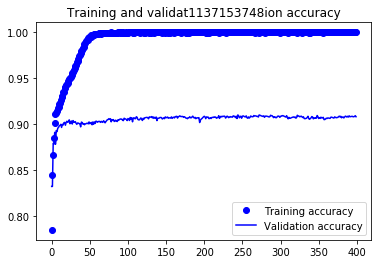

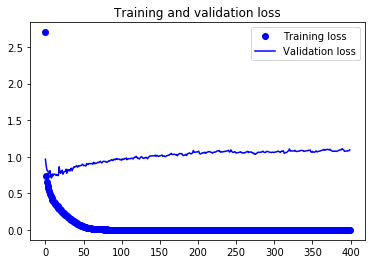

In [12]:
import matplotlib.pyplot as plt
accuracy = train_out.history['acc']
val_accuracy = train_out.history['val_acc']
loss = train_out.history['loss']
val_loss = train_out.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validat1137153748ion accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## INFERENCE

In [13]:
encoder_model = Model([k_image_input,k_question_input], k_encoder_states)
decoder_state_input_h = Input(shape=(embed_size,))
decoder_state_input_c = Input(shape=(embed_size,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = k_decoder_lstm(k_decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = k_decoder_dense(decoder_outputs)
decoder_model = Model([k_decoder_inputs] + decoder_states_inputs,[decoder_outputs] + decoder_states)

In [14]:
def decode_sequence(image_features,input_seq):
    # Encode the input as state vectors.
  
    states_value = encoder_model.predict([image_features,input_seq])

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, vocabulary_size))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, 1] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx_to_word[sampled_token_index]
        decoded_sentence += sampled_char
        decoded_sentence +=" "

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '2' or
           len(decoded_sentence) > PADDING_LEN-1):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, vocabulary_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

## LOAD PREPROCESSED TEST DATASET

In [15]:
#Open inputs of test dataset
file = open('image_feature_test.pkl', 'rb')
features_test = pickle.load(file)
file2 = open('test_df_v_final.pkl', 'rb')
df_test= pickle.load(file2)

In [16]:
test_questions=np.array(df_test['Q_Encoded'])
test_questions=np.array([np.array(item) for item in test_questions])

In [17]:
#use model to predict the answer
predicted_answers_test=[]
for seq_index in range(len(df_test)):
    input_seq = test_questions[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(features_test[seq_index: seq_index + 1], input_seq)
    predicted_answers_test.append(decoded_sentence.split(' '))

In [18]:
predicted_answers_test[0:5]

[['yes', '<END>', '<NULL>', ''],
 ['yes', '<END>', '<NULL>', ''],
 ['yes', '<END>', '<NULL>', ''],
 ['yes', '<END>', '<NULL>', ''],
 ['one', '<END>', '<NULL>', '']]

In [19]:
predicted_answers_test=[item[0:len(item)-1] for item in predicted_answers_test]

In [20]:
#function used to remove end tokens from the predicted answers
def find_end(item,st):
    for i in range(0,len(item)):
        if item[i]==st:
            return i
    return i+1  
predicted_answers_test=[item[0:find_end(item,'<END>')] for item in predicted_answers_test]

In [21]:
#actual/target answers
test_answers=np.array(df_test['A_parsed'])
test_answers=[item for item in test_answers]

In [22]:
#Final BLEU Score
score = corpus_bleu(test_answers, predicted_answers_test)
print(score)

0.029316419746460643


/usr/lib/python3/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
